![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Dataset: UCI Cervical Cancer

In this Notebook we will show you how to analyse and properly preprocess the UCI Cervical Cancer dataset. 

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirments on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/data/datasets_sklearn/Dataset-CervicalCancer.ipynb)



Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
# from google.colab import drive
# drive.mount('/content/drive')

# Switch to correct folder'
# %cd /content/drive/MyDrive

# Don't run this cell if you already cloned the repo 
# !git clone --branch main https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
# %cd XAI-Tutorials

# Install additional packages
# %pip install ucimlrepo

### Imports

Let's start with importing all required Python packages.

In [2]:
# Load the required packages
import pickle
import pprint
import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo 
from sklearn.impute import KNNImputer

pp = pprint.PrettyPrinter(depth=4)

import utils

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [3]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## The UCI Cervical Cancer Dataset

In this notebook, we will work with the **UCI Cervical Cancer dataset**, containing medical records of 858 patients with 803 healthy patients (class 0) and 55 patients with biopsy indicating cervical cancer (class 1). Diagnosis outcome is described by 29 features covering demographic information, habits, and historic medical records (for more details please see descrption [here](https://archive.ics.uci.edu/dataset/383/cervical+cancer+risk+factors)).

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_cervicalcancer.jpg?raw=true" width="700" /></center>

<font size=1> Source: [Link](https://www.kaggle.com/datasets/loveall/cervical-cancer-risk-classification)

In [4]:
# Load the data
cervical_cancer_risk_factors = fetch_ucirepo(id=383) 

Now, let's have a look at the description of the dataset:

In [5]:
# metadata 
pp.pprint(cervical_cancer_risk_factors.metadata)    

{'abstract': 'This dataset focuses on the prediction of indicators/diagnosis '
             'of cervical cancer. The features cover demographic information, '
             'habits, and historic medical records.',
 'additional_info': {'citation': None,
                     'funded_by': None,
                     'instances_represent': None,
                     'preprocessing_description': None,
                     'purpose': None,
                     'recommended_data_splits': None,
                     'sensitive_data': None,
                     'summary': "The dataset was collected at 'Hospital "
                                "Universitario de Caracas' in Caracas, "
                                'Venezuela. The dataset comprises demographic '
                                'information, habits, and historic medical '
                                'records of 858 patients. Several patients '
                                'decided not to answer some of the questions '
     

Before we can start analysing the dataset, we have to pre-process it to retrieve the desired features and target variable.

In [6]:
data_cervicalcancer = cervical_cancer_risk_factors.data.features

# Drop unnecessary columns (alternative target columns for either different diagnosis (DX) or tests)
data_cervicalcancer = data_cervicalcancer.drop(columns=['Citology', 'Schiller', 'Hinselmann', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx'])

# Convert Biopsy column to categorical labels
data_cervicalcancer['Biopsy'] = data_cervicalcancer['Biopsy'].map({0: '0_Healthy', 1: '1_Cancer'})

# Define which features are categorical
features_categorical = ['Biopsy','Smokes','Hormonal Contraceptives','IUD','STDs','STDs:condylomatosis','STDs:cervical condylomatosis','STDs:vaginal condylomatosis','STDs:vulvo-perineal condylomatosis','STDs:syphilis','STDs:pelvic inflammatory disease','STDs:genital herpes','STDs:molluscum contagiosum','STDs:AIDS','STDs:HIV','STDs:Hepatitis B','STDs:HPV']

### Exploratory Data Analysis

Exploratory data analysis is a first important step to get an understanding of the data and to identify patterns and problems in the data. First, we will check how many samples and variables our dataset has and inspect the first few lines of our dataset:

In [7]:
# Inspect the data
print(f"The dataset has {data_cervicalcancer.shape[1]} variables that describe {data_cervicalcancer.shape[0]} patients.")
print(f"We have {data_cervicalcancer.select_dtypes(include='object').shape[1]} categorical and {data_cervicalcancer.select_dtypes(exclude='object').shape[1]} numerical variables.")
print(f"We have the folliwng number of healthy and cancer patients in the dataset: \n {data_cervicalcancer['Biopsy'].value_counts()}")

The dataset has 29 variables that describe 858 patients.
We have 1 categorical and 28 numerical variables.
We have the folliwng number of healthy and cancer patients in the dataset: 
 0_Healthy    803
1_Cancer      55
Name: Biopsy, dtype: int64


In [8]:
print("\nHere are the first few lines of our dataset:")
data_cervicalcancer


Here are the first few lines of our dataset:


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0_Healthy
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0_Healthy
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0_Healthy
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0_Healthy
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0_Healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,3.0,18.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0_Healthy
854,32,2.0,19.0,1.0,0.0,0.0,0.0,1.0,8.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0_Healthy
855,25,2.0,17.0,0.0,0.0,0.0,0.0,1.0,0.08,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0_Healthy
856,33,2.0,24.0,2.0,0.0,0.0,0.0,1.0,0.08,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0_Healthy


Next, we check if any values are missing:

In [9]:
print(data_cervicalcancer.isnull().sum())

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

And last, we inspect how our variables are distributed:

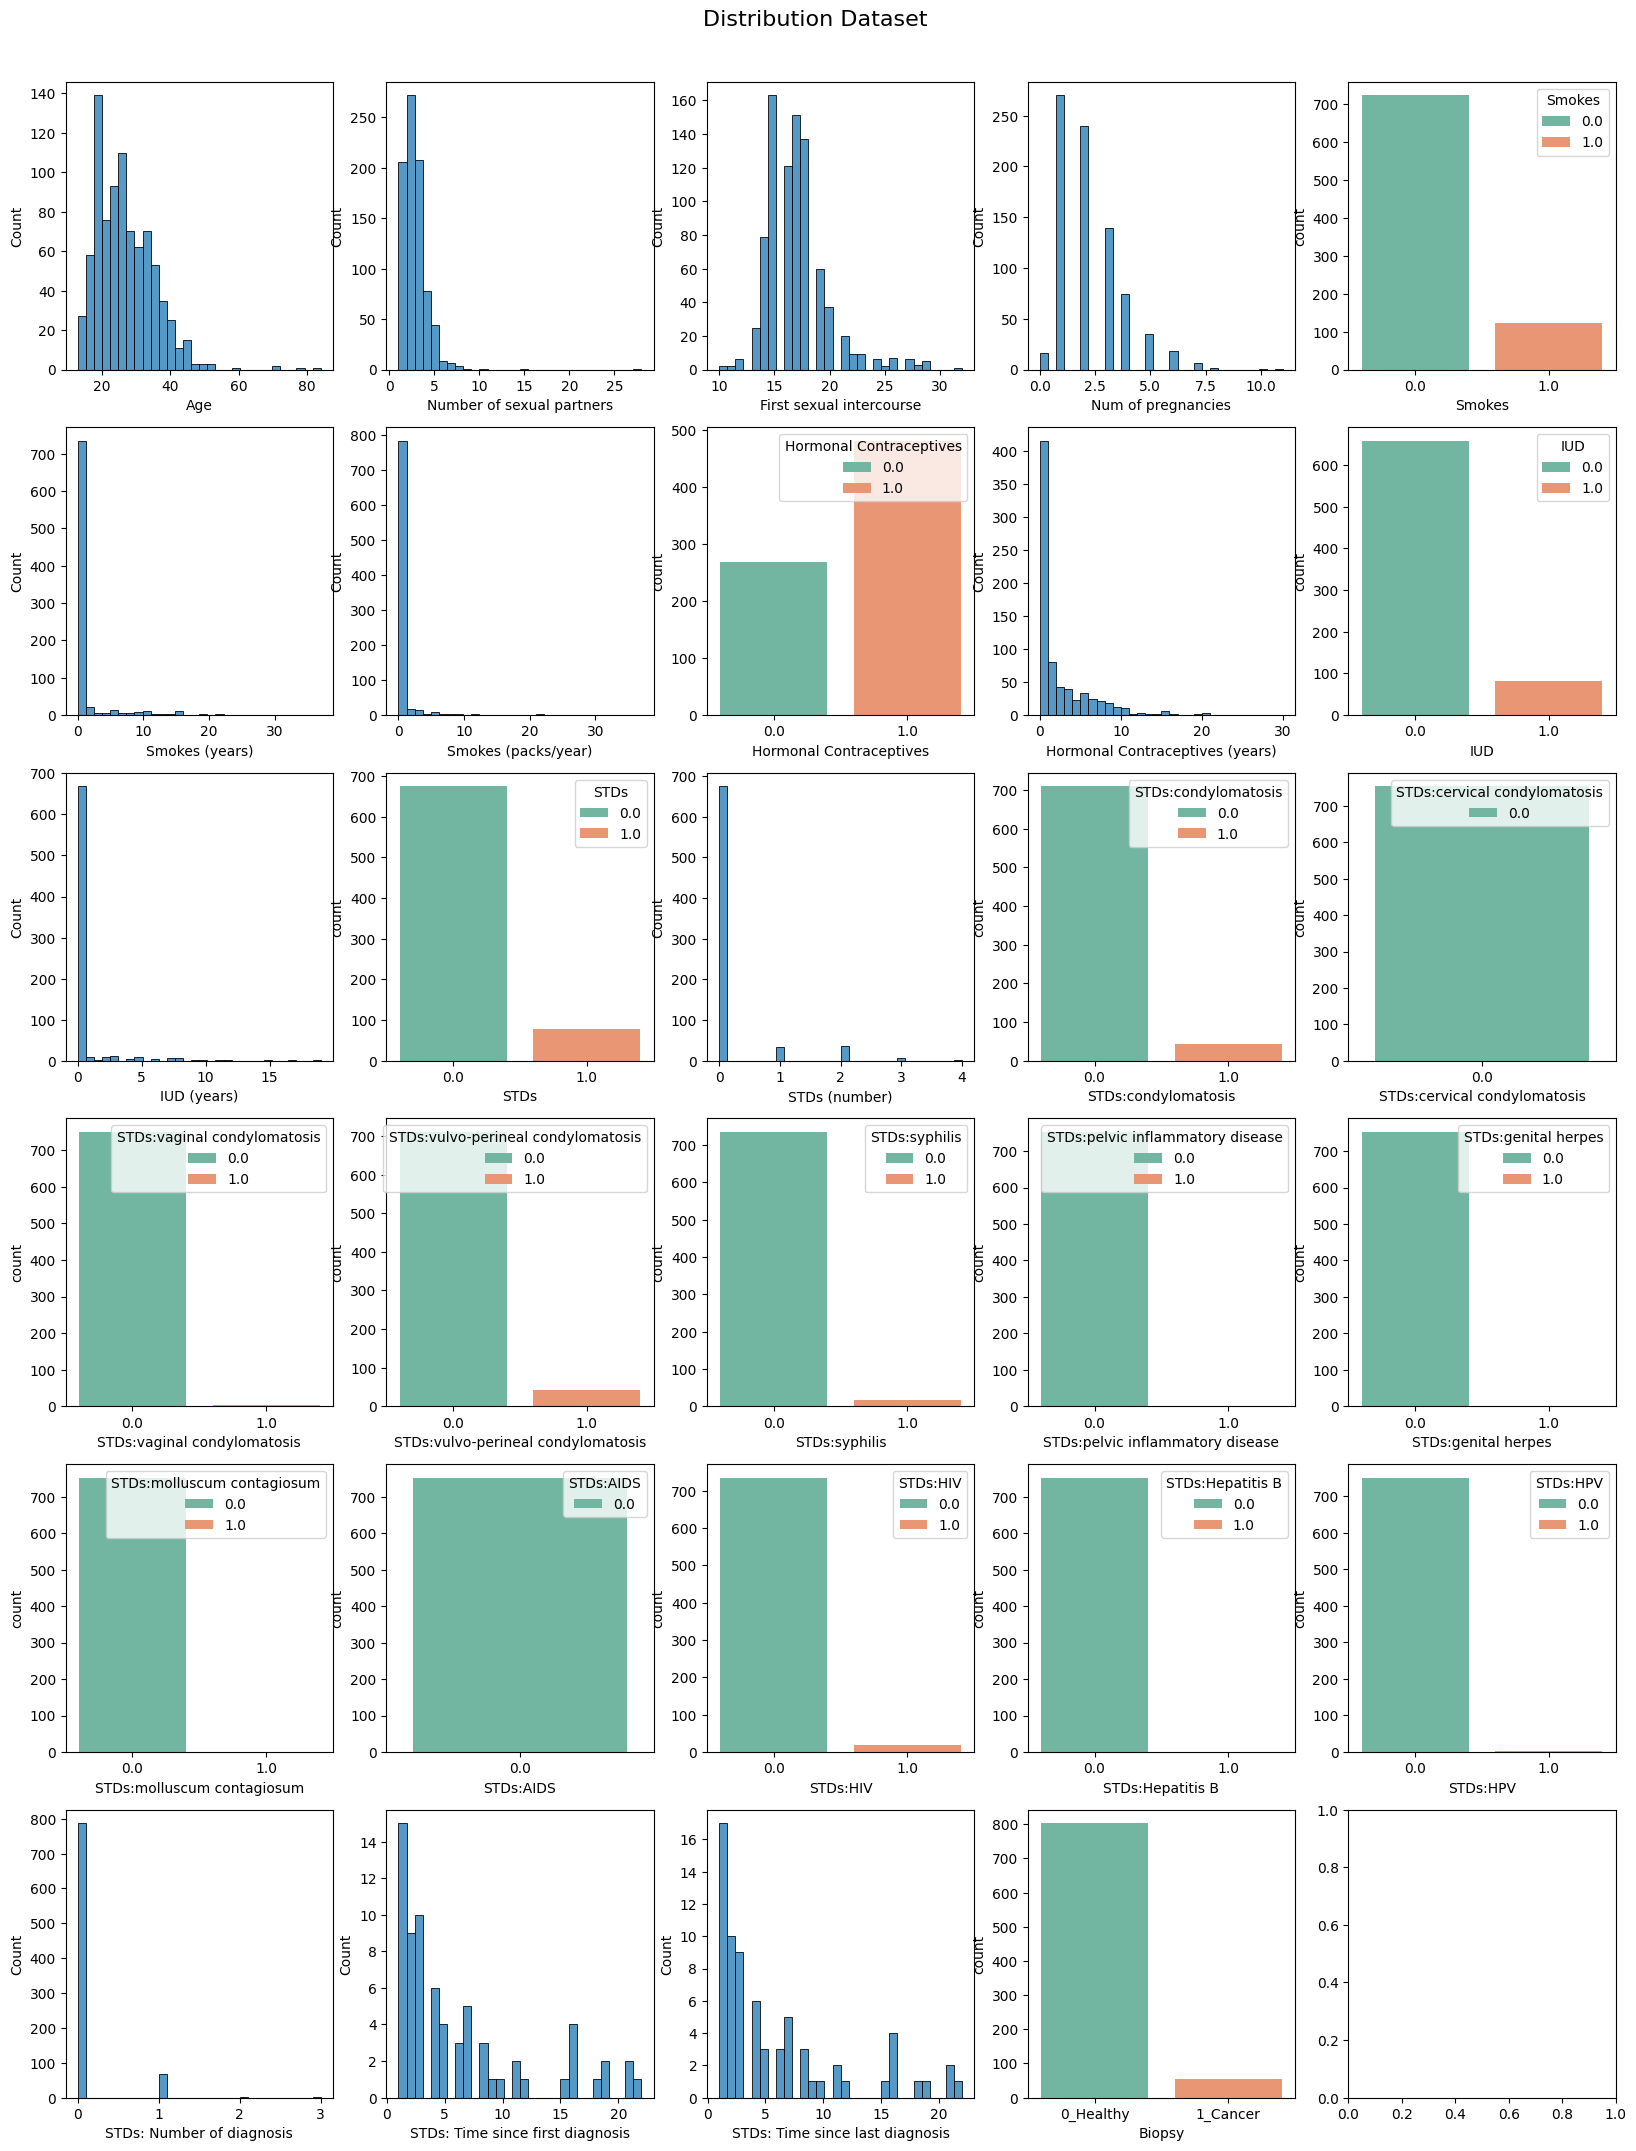

In [10]:
utils.plot_distributions(dataset=data_cervicalcancer, features_categorical=features_categorical, ncols=5, nrows=6)

By analysing the results of the EDA we can conclude:

- we have missing values in the dataset we need to take care of
- we need to encode categorical features for the classification model

## Data Preprocessing

### Handling of Missing Values 

Based on what we saw in the explorative analysis above, we need to do some preprocessing steps before we start training the model. First, we need to take care of the missing values. There are different options how one can deal with this problem and the strategy one chooses depends heavily on the dataset and the context we are in.

In this dataset, we cannot handle all missing values with one approach but choose accordingly:

- the fratures "STDs: Time since first diagnosis" and "STDs: Time since last diagnosis" have more than 90% missing values, hence we remove those features entirely
- the features "STDs:xx" have more than 10% missing values, however, removing them would lead to a loss of ~20% "cancer" patients. Since the "cancer" class is already underrepresented in our dataset, we want to avoid loosing too many samples of this class. On the other hand, we have to consider that imputing those values might be difficult since we can see from the distribution plots that we have a high imbalance in no STD vs STD. This is why we decide to drop the single "STDs:xx" value and only keep the aggregation features "STDs" and STDs (number). Since we have more balanced data here, it's more reliable to impute the missing values of those features.
- remaining features: for the ramining features we impute the missing values to keep all "cancer" class samples in the dataset. We choose the KNN Imputer as it is more sophisticated than a simple mean/median/most_frequent imputer. In order to use the KNN imputer, we have to remove the target variable "biopsy" from the dataset beforehand as this would influence in an overly optimistic way our classification model.

In [11]:
# remove features we can't reliably impute
std_time = ['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis']
std_xx = ['STDs:condylomatosis','STDs:cervical condylomatosis','STDs:vaginal condylomatosis','STDs:vulvo-perineal condylomatosis','STDs:syphilis','STDs:pelvic inflammatory disease','STDs:genital herpes','STDs:molluscum contagiosum','STDs:AIDS','STDs:HIV','STDs:Hepatitis B','STDs:HPV']

data_cervicalcancer = data_cervicalcancer.drop(columns=std_time)
data_cervicalcancer = data_cervicalcancer.drop(columns=std_xx)

In [12]:
print(data_cervicalcancer.isnull().sum())

Age                                  0
Number of sexual partners           26
First sexual intercourse             7
Num of pregnancies                  56
Smokes                              13
Smokes (years)                      13
Smokes (packs/year)                 13
Hormonal Contraceptives            108
Hormonal Contraceptives (years)    108
IUD                                117
IUD (years)                        117
STDs                               105
STDs (number)                      105
STDs: Number of diagnosis            0
Biopsy                               0
dtype: int64


In [13]:
# impute missing values for remaining features using KNN Imputer
data_cervicalcancer_imp = data_cervicalcancer.drop(columns=["Biopsy"])
imputer = KNNImputer(n_neighbors=5, weights="distance")
imputer.set_output(transform="pandas")
data_cervicalcancer_imp = imputer.fit_transform(data_cervicalcancer_imp)
data_cervicalcancer_imp["Biopsy"] = data_cervicalcancer["Biopsy"]

print(data_cervicalcancer_imp.isnull().sum())

Age                                0
Number of sexual partners          0
First sexual intercourse           0
Num of pregnancies                 0
Smokes                             0
Smokes (years)                     0
Smokes (packs/year)                0
Hormonal Contraceptives            0
Hormonal Contraceptives (years)    0
IUD                                0
IUD (years)                        0
STDs                               0
STDs (number)                      0
STDs: Number of diagnosis          0
Biopsy                             0
dtype: int64


Since we also imputed missing values for categorical features, we need to convert the imputed values to categories, simply by rounding the imputed values.

In [14]:
for col in data_cervicalcancer_imp.columns:
    if col in features_categorical and col not in ["Biopsy"]:
        data_cervicalcancer_imp[col] = round(data_cervicalcancer_imp[col])
        data_cervicalcancer_imp[col] = data_cervicalcancer_imp[col].map({0: 'No', 1: 'Yes'})

Let's have another look at the distribution of the features we will keep in the dataset.

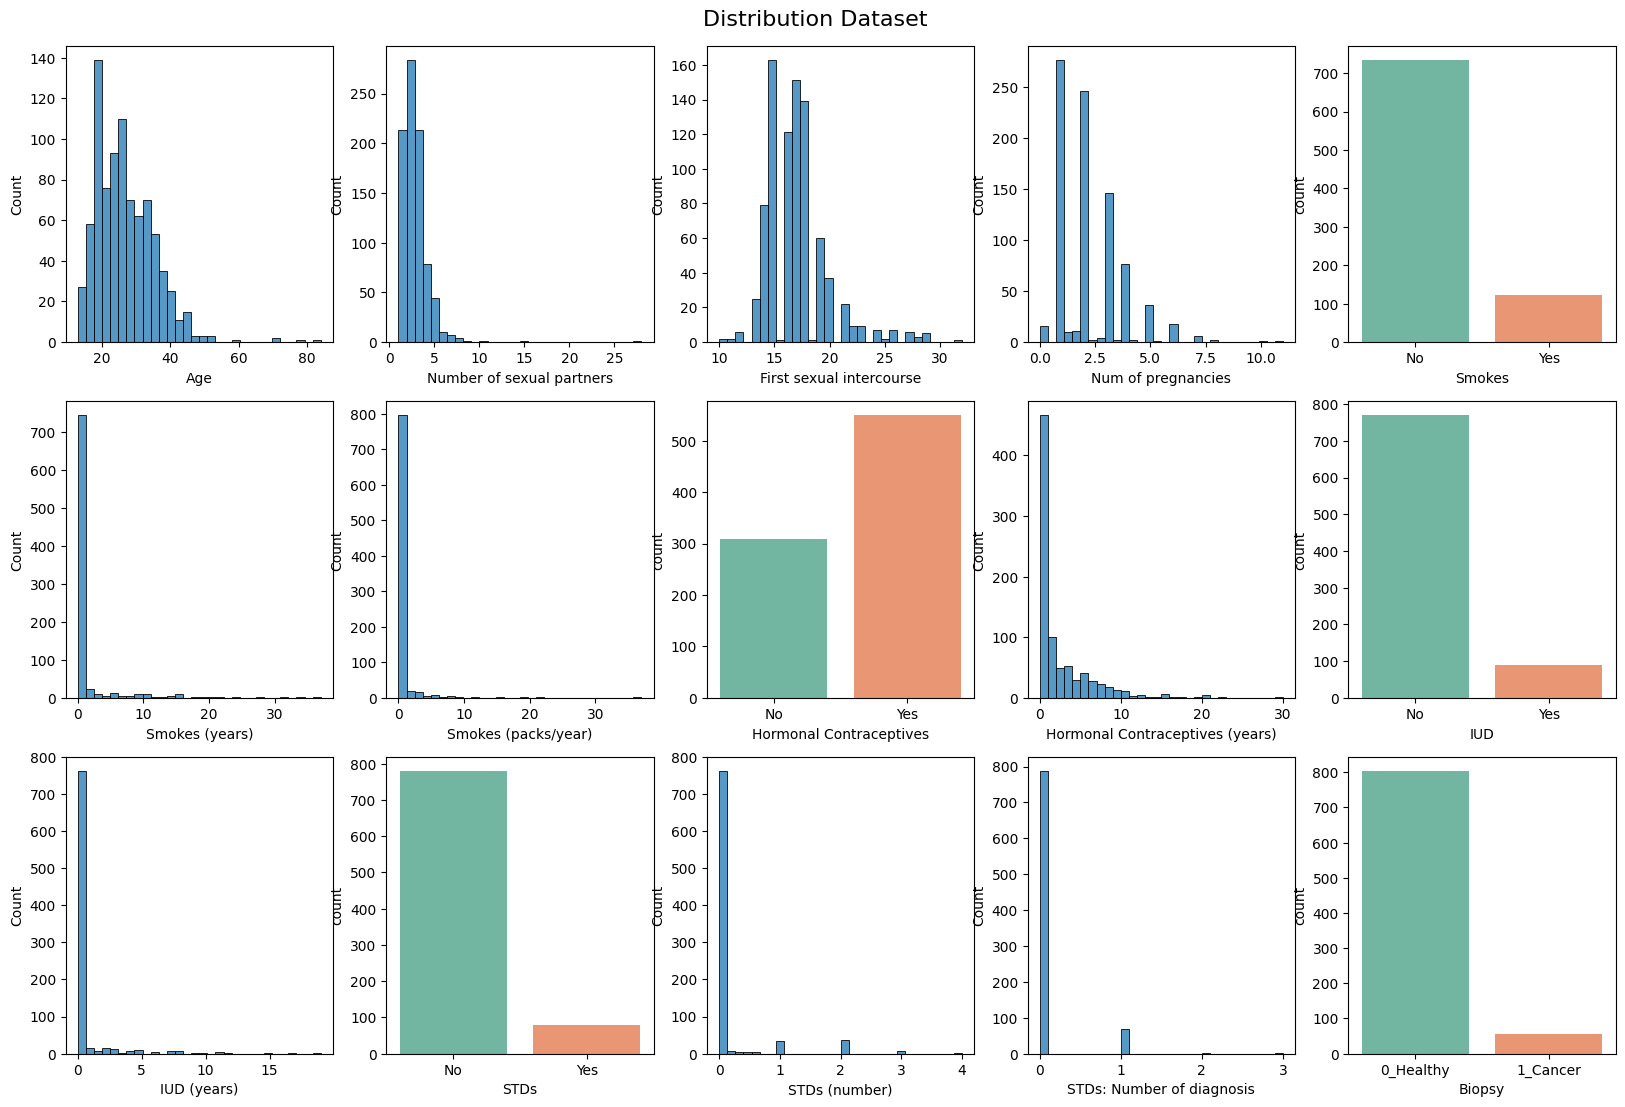

In [15]:
utils.plot_distributions(dataset=data_cervicalcancer_imp, features_categorical=features_categorical, ncols=5, nrows=3)

The distribution for the features with imputed values looks similar to the original distribution, which is a good sign for a suitable imputation. Is our dataset ready to be used for training the model?  
Well...almost! What did we observe regarding feature transformation? Do we need to encode some of them? Yes, we do! 

### Encoding of categorical variables

Categorical features need to be encoded, i.e. turned into numerical data. This is essential because most machine learning models can only interpret numerical data and not data in a text form. As with many data preprocessing steps, there are multiple strategies one can apply to encode the categorical features. 

Here, we will use a simple **dummy encoding** for the categorical features, which will transform the categorical feature values into one-hot encoded vectors. Remeber that our goal is to predict the Biopsy outcome and hence, our target variable *"Biopsy"* does not need to be encoded, because it will be interepreted as different classes by the Random Forest Classifier.

In [16]:
# preprocess categorical features such that they can be used for the RF model
data_cervicalcancer_encoded = pd.get_dummies(data_cervicalcancer_imp, columns=['Smokes','Hormonal Contraceptives','IUD','STDs'], prefix=['Smokes','Hormonal Contraceptives','IUD','STDs'], drop_first=True)
data_cervicalcancer_encoded.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs: Number of diagnosis,Biopsy,Smokes_Yes,Hormonal Contraceptives_Yes,IUD_Yes,STDs_Yes
0,18.0,4.0,15.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0_Healthy,0,0,0,0
1,15.0,1.0,14.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0_Healthy,0,0,0,0
2,34.0,1.0,24.015132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0_Healthy,0,0,0,0
3,52.0,5.0,16.000000,4.0,37.0,37.0,3.0,0.0,0.0,0.0,0_Healthy,1,1,0,0
4,46.0,3.0,21.000000,4.0,0.0,0.0,15.0,0.0,0.0,0.0,0_Healthy,0,1,0,0


Note, that the option ``drop_first=True`` leads to k-1 dummies out of k categorical levels by removing the first level. However, it still contains the same amount of information. 

Let's now save the dataset in a ``pickle`` file, such that we can load the preprocessed data into other notebooks later on.

In [17]:
# Save the data with joblib
data = data_cervicalcancer_encoded

with open('data_cervicalcancer_preprocessed.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)